# HW3_Q8_Chami

In [11]:
# libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_dataset = datasets.ImageFolder(root="train", transform=transform)
val_dataset   = datasets.ImageFolder(root="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = 5


## Part 1

In [4]:
# training function
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total
# validation loop
def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / total, correct / total


In [5]:
# part 1 : fully linear model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 224 * 224, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

In [6]:
# part 1: one hidden 
class OneHiddenReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 224 * 224, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
# part 1: imrpoved model
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 224 * 224, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)


In [8]:
# train model
def train_model(model, optimizer, num_epochs=20, patience=5):
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = np.inf
    counter = 0

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Acc={tr_acc:.3f}, Val Acc={val_acc:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accs, val_accs


Epoch 1: Train Acc=0.372, Val Acc=0.360
Epoch 2: Train Acc=0.450, Val Acc=0.358
Epoch 3: Train Acc=0.473, Val Acc=0.287
Epoch 4: Train Acc=0.492, Val Acc=0.363
Epoch 5: Train Acc=0.542, Val Acc=0.443
Epoch 6: Train Acc=0.549, Val Acc=0.431
Epoch 7: Train Acc=0.577, Val Acc=0.445
Epoch 8: Train Acc=0.614, Val Acc=0.431
Epoch 9: Train Acc=0.624, Val Acc=0.408
Epoch 10: Train Acc=0.644, Val Acc=0.502
Epoch 11: Train Acc=0.651, Val Acc=0.518
Epoch 12: Train Acc=0.676, Val Acc=0.447
Early stopping triggered.
Epoch 1: Train Acc=0.339, Val Acc=0.415
Epoch 2: Train Acc=0.458, Val Acc=0.406
Epoch 3: Train Acc=0.513, Val Acc=0.469
Epoch 4: Train Acc=0.557, Val Acc=0.409
Epoch 5: Train Acc=0.608, Val Acc=0.509
Epoch 6: Train Acc=0.641, Val Acc=0.554
Epoch 7: Train Acc=0.656, Val Acc=0.574
Epoch 8: Train Acc=0.667, Val Acc=0.416
Epoch 9: Train Acc=0.689, Val Acc=0.513
Epoch 10: Train Acc=0.703, Val Acc=0.622
Epoch 11: Train Acc=0.731, Val Acc=0.537
Epoch 12: Train Acc=0.758, Val Acc=0.679
Epoch 13

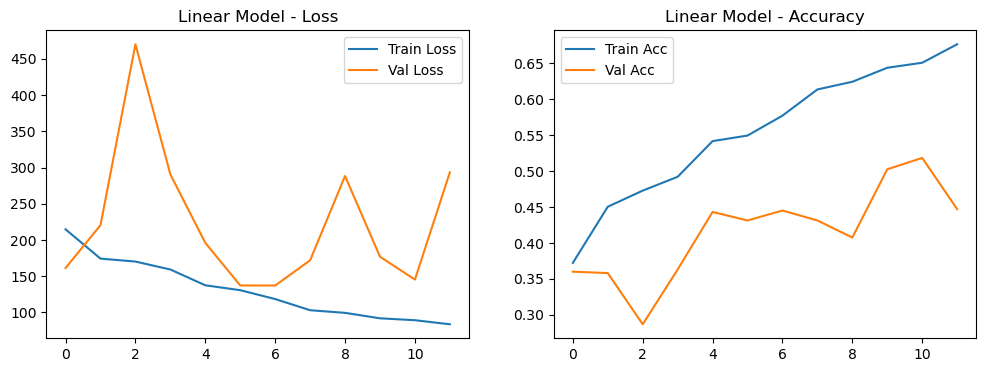

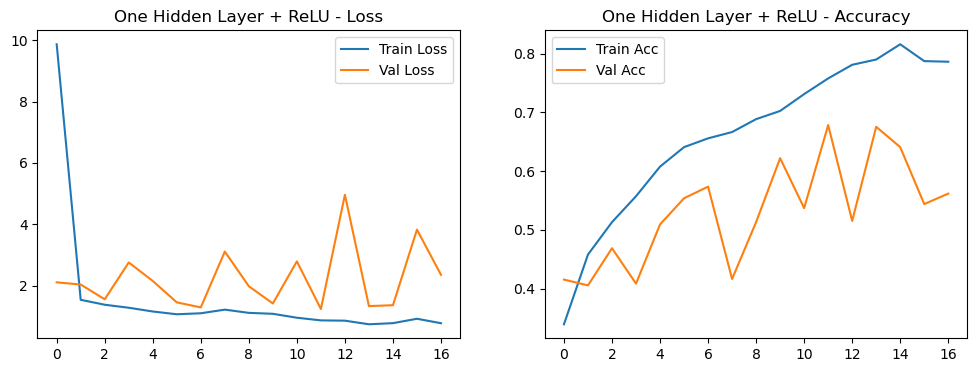

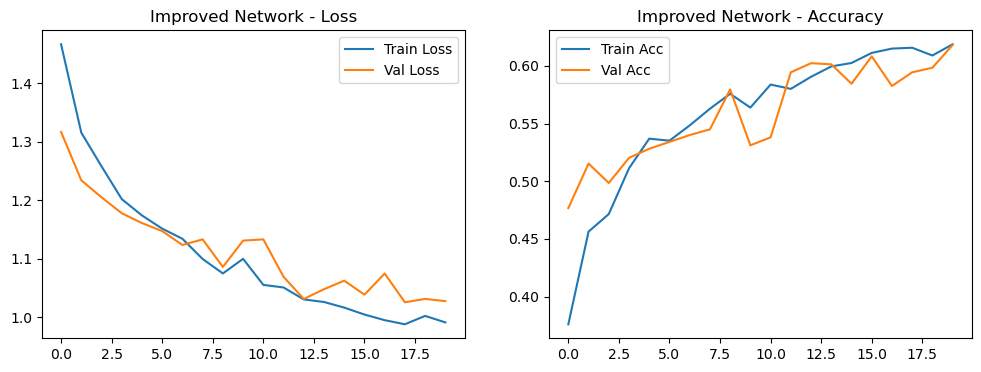

In [9]:
#training 
# Model 1
linear_model = LinearModel()
optimizer1 = optim.SGD(linear_model.parameters(), lr=0.01)
history_linear = train_model(linear_model, optimizer1)

# Model 2
relu_model = OneHiddenReLU()
optimizer2 = optim.SGD(relu_model.parameters(), lr=0.01)
history_relu = train_model(relu_model, optimizer2)

# Model 3 (L2 via weight_decay)
improved_model = ImprovedNet()
optimizer3 = optim.Adam(improved_model.parameters(), lr=0.001, weight_decay=1e-4)
history_improved = train_model(improved_model, optimizer3)

#plot and acc
def plot_curves(history, title):
    train_losses, val_losses, train_accs, val_accs = history

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(title + " - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.show()

plot_curves(history_linear, "Linear Model")
plot_curves(history_relu, "One Hidden Layer + ReLU")
plot_curves(history_improved, "Improved Network")


## Part 2

In [12]:
class AlexNetTransfer(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        alexnet = models.alexnet(pretrained=True)

        # freeze backbone
        for param in alexnet.features.parameters():
            param.requires_grad = False

        self.features = alexnet.features
        self.avgpool = alexnet.avgpool

        # new classifier head
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\AMIR HOSSEIN/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:57<00:00, 4.28MB/s]


Epoch 1: Train Acc=0.745, Val Acc=0.862
Epoch 2: Train Acc=0.894, Val Acc=0.906
Epoch 3: Train Acc=0.938, Val Acc=0.932
Epoch 4: Train Acc=0.954, Val Acc=0.938
Epoch 5: Train Acc=0.970, Val Acc=0.937
Epoch 6: Train Acc=0.960, Val Acc=0.921
Epoch 7: Train Acc=0.955, Val Acc=0.914
Epoch 8: Train Acc=0.961, Val Acc=0.914
Epoch 9: Train Acc=0.951, Val Acc=0.901
Early stopping triggered.


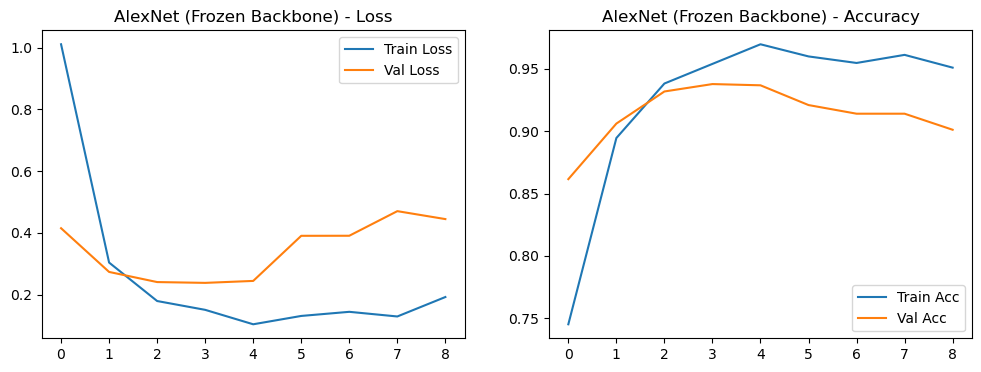

In [14]:
alex_model = AlexNetTransfer(num_classes)
optimizer_alex = optim.Adam(
    alex_model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

history_alex = train_model(alex_model, optimizer_alex)
plot_curves(history_alex, "AlexNet (Frozen Backbone)")


In [15]:
class VGG16Transfer(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        vgg = models.vgg16(pretrained=True)

        # freeze backbone
        for param in vgg.features.parameters():
            param.requires_grad = False

        self.features = vgg.features
        self.avgpool = vgg.avgpool

        # new classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


C:\Users\AMIR HOSSEIN\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\AMIR HOSSEIN/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [02:10<00:00, 4.25MB/s]


Epoch 1: Train Acc=0.769, Val Acc=0.896
Epoch 2: Train Acc=0.946, Val Acc=0.917
Epoch 3: Train Acc=0.965, Val Acc=0.899
Epoch 4: Train Acc=0.968, Val Acc=0.919
Epoch 5: Train Acc=0.925, Val Acc=0.872
Epoch 6: Train Acc=0.926, Val Acc=0.788
Early stopping triggered.


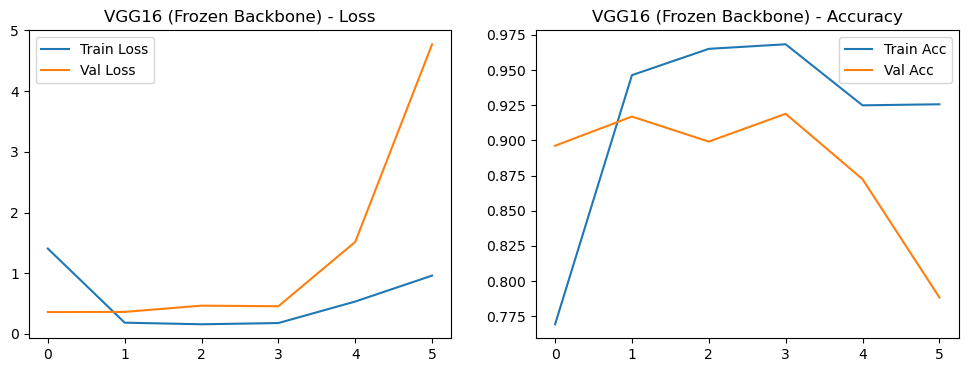

In [16]:
vgg_model = VGG16Transfer(num_classes)
optimizer_vgg = optim.Adam(
    vgg_model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

history_vgg = train_model(vgg_model, optimizer_vgg)
plot_curves(history_vgg, "VGG16 (Frozen Backbone)")
